# Quality Control the rift measurement algorithm 

### import necessary libraries

In [1]:
import pickle
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import matplotlib.pyplot as plt
import rasterio
import math
import scipy
from rasterio.plot import show
from matplotlib.patches import Rectangle
from datetime import datetime
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy import stats
from scipy.stats import linregress
from shapely.geometry import Point, Polygon
from pyproj import Transformer
from pyproj import Geod

### Load saved pickles of ATL06 data and rift observations

In [2]:
shelf_name = 'brunt'

# ATL06 data
atl06_file_name = '/data/fast1/arc/atl06/' + shelf_name + '.pkl'
with open(atl06_file_name, 'rb') as handle:
    atl06_data = pickle.load(handle)
atl06_data = pd.DataFrame(atl06_data)

# rift obs
rift_obs_path = '/home/ram21/notebooks/brunt-is2-rifts/' + shelf_name + '_himedlow_mdt.pkl'
with open(rift_obs_path, 'rb') as handle:
    rift_obs = pickle.load(handle)

# convert to GeoDataFrame 
rift_obs = gpd.GeoDataFrame(rift_obs, geometry=gpd.points_from_xy(rift_obs['x-centroid'], rift_obs['y-centroid']))


In [3]:
display(rift_obs)

d-start         d-end        x-start       y-start          x-end  \
0      1.905276e+06  1.905551e+06 -565613.247077  1.819384e+06 -565658.698762   
1      1.638777e+06  1.639809e+06 -524018.302648  1.552738e+06 -524194.914786   
2      1.905278e+06  1.905533e+06 -565624.512822  1.819382e+06 -565666.793309   
3      1.638779e+06  1.639810e+06 -524025.459757  1.552737e+06 -524202.128991   
4      1.915758e+06  1.916013e+06 -517505.036854  1.844537e+06 -517607.709994   
...             ...           ...            ...           ...            ...   
20438  1.822517e+06  1.822928e+06 -509826.612784  1.749756e+06 -509996.894363   
20439  1.822987e+06  1.823144e+06 -510020.881659  1.750189e+06 -510085.142536   
20440  1.823261e+06  1.823359e+06 -510134.062384  1.750441e+06 -510174.684009   
20441  1.824510e+06  1.824706e+06 -507405.095265  1.752535e+06 -507486.106762   
20442  1.826273e+06  1.826449e+06 -508134.978845  1.754158e+06 -508207.218023   

              y-end     x-centroid    y-centroid  lat-centroid  lon-centroid  \
0      1.819658e+06 -565635.972919  1.819521e+06    -72.592951    -17.268946   
1      1.553767e+06 -524106.608717  1.553253e+06    -74.995383    -18.645689   
2      1.819636e+06 -565645.653066  1.819509e+06    -72.593025    -17.269328   
3      1.553766e+06 -524113.794374  1.553252e+06    -74.995373    -18.645941   
4      1.844773e+06 -517556.373424  1.844655e+06    -72.498703    -15.672569   
...             ...            ...           ...           ...           ...   
20438  1.750134e+06 -509911.753574  1.749945e+06    -73.337964    -16.245453   
20439  1.750333e+06 -510053.012097  1.750261e+06    -73.334872    -16.246937   
20440  1.750531e+06 -510154.373197  1.750486e+06    -73.332664    -16.248013   
20441  1.752715e+06 -507445.601013  1.752625e+06    -73.320958    -16.147560   
20442  1.754321e+06 -508171.098434  1.754240e+06    -73.305152    -16.155334   

       ...  sl_offset                             time  rgt     azimuth  \
0      ...    4.50581 2018-10-14 04:18:16.593302+00:00  237 -172.192581   
1      ...   3.474985 2018-10-14 04:18:16.593302+00:00  237 -171.298981   
2      ...   5.267474 2018-10-14 04:18:16.593302+00:00  237 -172.185532   
3      ...    3.36491 2018-10-14 04:18:16.593302+00:00  237 -171.289032   
4      ...    2.29238 2018-10-14 17:00:12.818769+00:00  245   -7.779661   
...    ...        ...                              ...  ...         ...   
20438  ...        NaN 2021-07-13 17:09:51.202160+00:00  306   -8.044339   
20439  ...        NaN 2021-07-13 17:09:51.202160+00:00  306   -8.043275   
20440  ...        NaN 2021-07-13 17:09:51.202160+00:00  306   -8.042513   
20441  ...   4.089682 2021-07-13 17:09:51.202160+00:00  306   -8.040342   
20442  ...   -5.55771 2021-07-13 17:09:51.202160+00:00  306   -8.034925   

          sigma          h beam  data_row  confidence  \
0      0.167704  10.356703   2l         1        high   
1      0.045503  20.327535   3l         2      medium   
2      0.130750   9.449120   2r         4        high   
3      0.025289  20.303390   3r         5      medium   
4      0.135998  12.588929   2l         7        high   
...         ...        ...  ...       ...         ...   
20438  0.053835        NaN   1r     15337         low   
20439  0.104968        NaN   1r     15337         low   
20440  0.140408        NaN   1r     15337         low   
20441  0.062050  22.907100   2r     15338      medium   
20442  0.065469  16.220777   2r     15338        high   

                              geometry  
0      POINT (-565635.973 1819520.879)  
1      POINT (-524106.609 1553252.901)  
2      POINT (-565645.653 1819509.216)  
3      POINT (-524113.794 1553251.649)  
4      POINT (-517556.373 1844655.076)  
...                                ...  
20438  POINT (-509911.754 1749944.909)  
20439  POINT (-510053.012 1750260.865)  
20440  POINT (-510154.373 1750486.342)  
20441  POINT (-507445.601 1752624.949)  
20442  POINT (-508171.098 1754239.713)  


### Halloween Crack bounding box
An approximate bounding box to subset rift observations to the Halloween Crack

In [4]:
coords = [(-701000,1424000), (-685000,1427500), (-670000,1435000), (-660000,1450000),
         (-655000,1458000),(-685000,1436000),(-703000,1425000)]
poly = Polygon(coords)
box_x,box_y = poly.exterior.xy


### Subset rifts observations to Halloween Crack

In [5]:
halloween_obs = rift_obs[rift_obs.within(poly)]

#with open('/home/ram21/notebooks/brunt-is2-rifts/brunt_himedlow_mdt_halloween.pickle', 'wb') as handle:
#    pickle.dump(halloween_obs, handle, protocol=pickle.HIGHEST_PROTOCOL)


### Merge Halloween Crack observations across icebergs/semi-detached ice blocks using a separation distance of up to 500 m
The rift is occassionally bisected by icebergs or semi-detached ice blocks which originate from the initial opening of the rift. It is necessary to combine them to calculate the "opening width" for comparison with GNSS (see Supplementary figure 5)

In [6]:
#display(halloween_obs)

transformer = Transformer.from_crs("EPSG:3031", "EPSG:4326")

#print(len(halloween_obs))

halloween_obs_merged = {
        "d-start": [],
        "d-end": [],
        "x-start": [],
        "y-start": [],
        "x-end": [],
        "y-end": [],
        "x-centroid": [],
        "y-centroid": [],
        "lat-centroid": [],
        "lon-centroid": [],
        "width": [],
        "non-iceberg-width": [],
        "d_seaward": [],
        "d_landward": [],
        "h_seaward": [],
        "h_landward": [],
        "sl_offset": [],
        "time": [],
        "rgt": [],
        "azimuth": [],
        "sigma": [],
        "h":[],
        "beam":[],
        "data_row":[],
        "confidence":[]
    }

switch = "no"

for i in range(0,len(halloween_obs)-1):
    this_rift_rgt     = halloween_obs["rgt"].iloc[i]
    this_rift_beam    = halloween_obs["beam"].iloc[i]
    this_rift_time    = halloween_obs["time"].iloc[i]
    this_rift_d_end   = halloween_obs["d-end"].iloc[i]
    next_rift_rgt     = halloween_obs["rgt"].iloc[i+1]
    next_rift_beam    = halloween_obs["beam"].iloc[i+1]
    next_rift_time    = halloween_obs["time"].iloc[i+1]
    next_rift_d_start = halloween_obs["d-start"].iloc[i+1]
    
    rift_sep = next_rift_d_start - this_rift_d_end
    
    if (this_rift_rgt == next_rift_rgt) & (this_rift_beam == next_rift_beam) & \
    (this_rift_time == next_rift_time) & (rift_sep < 500):
        halloween_obs_merged["d-start"].append(halloween_obs["d-start"].iloc[i])
        halloween_obs_merged["d-end"].append(halloween_obs["d-end"].iloc[i+1])
        halloween_obs_merged["x-start"].append(halloween_obs["x-start"].iloc[i])
        halloween_obs_merged["y-start"].append(halloween_obs["y-start"].iloc[i])
        halloween_obs_merged["x-end"].append(halloween_obs["x-end"].iloc[i+1])
        halloween_obs_merged["y-end"].append(halloween_obs["y-end"].iloc[i+1])
        halloween_obs_merged["x-centroid"].append((halloween_obs["x-start"].iloc[i]+halloween_obs["x-end"].iloc[i+1])/2)
        halloween_obs_merged["y-centroid"].append((halloween_obs["y-start"].iloc[i]+halloween_obs["y-end"].iloc[i+1])/2)
        [rift_centroid_lat,rift_centroid_lon] = transformer.transform(\
                                            (halloween_obs["x-start"].iloc[i]+halloween_obs["x-end"].iloc[i+1])/2, \
                                            (halloween_obs["y-start"].iloc[i]+halloween_obs["y-end"].iloc[i+1])/2)
        halloween_obs_merged["lat-centroid"].append(rift_centroid_lat)
        halloween_obs_merged["lon-centroid"].append(rift_centroid_lon)
        halloween_obs_merged["width"].append(halloween_obs["d-end"].iloc[i+1]-halloween_obs["d-start"].iloc[i])
        halloween_obs_merged["non-iceberg-width"].append(halloween_obs["width"].iloc[i]+halloween_obs["width"].iloc[i+1])
        halloween_obs_merged["d_seaward"].append(halloween_obs["d_seaward"].iloc[i+1])
        halloween_obs_merged["d_landward"].append(halloween_obs["d_landward"].iloc[i])
        halloween_obs_merged["h_seaward"].append(halloween_obs["h_seaward"].iloc[i+1])
        halloween_obs_merged["h_landward"].append(halloween_obs["h_landward"].iloc[i])
        halloween_obs_merged["sl_offset"].append(halloween_obs["h_seaward"].iloc[i+1] - halloween_obs["h_landward"].iloc[i])
        halloween_obs_merged["time"].append(halloween_obs["time"].iloc[i])
        halloween_obs_merged["rgt"].append(halloween_obs["rgt"].iloc[i])
        halloween_obs_merged["azimuth"].append((halloween_obs["azimuth"].iloc[i]+halloween_obs["azimuth"].iloc[i+1])/2)
        halloween_obs_merged["sigma"].append((halloween_obs["sigma"].iloc[i]+halloween_obs["sigma"].iloc[i+1])/2)
        halloween_obs_merged["h"].append((halloween_obs["h"].iloc[i]+halloween_obs["h"].iloc[i+1])/2)
        halloween_obs_merged["beam"].append(halloween_obs["beam"].iloc[i])
        halloween_obs_merged["data_row"].append(halloween_obs["data_row"].iloc[i])
        conf = [0,0]
        confid = []
        if halloween_obs["confidence"].iloc[i] == "high":
            conf[0] = 1
        elif halloween_obs["confidence"].iloc[i] == "medium":
            conf[0] = 2
        else:
            conf[0] = 3
        
        if halloween_obs["confidence"].iloc[i+1] == "high":
            conf[1] = 1
        elif halloween_obs["confidence"].iloc[i+1] == "medium":
            conf[1] = 2
        else:
            conf[1] = 3
            
        if np.min(conf) == 1:
            confid = "high"
        elif np.min(conf) == 2:
            confid = "medium"
        else:
            confid = "low"
            
        halloween_obs_merged["confidence"].append(confid)
        
        switch = "yes"
                
    else:
        
        if switch == "no":
            halloween_obs_merged["d-start"].append(halloween_obs["d-start"].iloc[i])
            halloween_obs_merged["d-end"].append(halloween_obs["d-end"].iloc[i])
            halloween_obs_merged["x-start"].append(halloween_obs["x-start"].iloc[i])
            halloween_obs_merged["y-start"].append(halloween_obs["y-start"].iloc[i])
            halloween_obs_merged["x-end"].append(halloween_obs["x-end"].iloc[i])
            halloween_obs_merged["y-end"].append(halloween_obs["y-end"].iloc[i])
            halloween_obs_merged["x-centroid"].append(halloween_obs["x-centroid"].iloc[i])
            halloween_obs_merged["y-centroid"].append(halloween_obs["y-centroid"].iloc[i])
            halloween_obs_merged["lat-centroid"].append(halloween_obs["lat-centroid"].iloc[i])
            halloween_obs_merged["lon-centroid"].append(halloween_obs["lon-centroid"].iloc[i])
            halloween_obs_merged["width"].append(halloween_obs["width"].iloc[i])
            halloween_obs_merged["non-iceberg-width"].append(halloween_obs["width"].iloc[i])
            halloween_obs_merged["d_seaward"].append(halloween_obs["d_seaward"].iloc[i])
            halloween_obs_merged["d_landward"].append(halloween_obs["d_landward"].iloc[i])
            halloween_obs_merged["h_seaward"].append(halloween_obs["h_seaward"].iloc[i])
            halloween_obs_merged["h_landward"].append(halloween_obs["h_landward"].iloc[i])
            halloween_obs_merged["sl_offset"].append(halloween_obs["sl_offset"].iloc[i])
            halloween_obs_merged["time"].append(halloween_obs["time"].iloc[i])
            halloween_obs_merged["rgt"].append(halloween_obs["rgt"].iloc[i])
            halloween_obs_merged["azimuth"].append(halloween_obs["azimuth"].iloc[i])
            halloween_obs_merged["sigma"].append(halloween_obs["sigma"].iloc[i])
            halloween_obs_merged["h"].append(halloween_obs["h"].iloc[i])
            halloween_obs_merged["beam"].append(halloween_obs["beam"].iloc[i])
            halloween_obs_merged["data_row"].append(halloween_obs["data_row"].iloc[i])
            halloween_obs_merged["confidence"].append(halloween_obs["confidence"].iloc[i])
        switch = "no"

if switch == "no":
    halloween_obs_merged["d-start"].append(halloween_obs["d-start"].iloc[i+1])
    halloween_obs_merged["d-end"].append(halloween_obs["d-end"].iloc[i+1])
    halloween_obs_merged["x-start"].append(halloween_obs["x-start"].iloc[i+1])
    halloween_obs_merged["y-start"].append(halloween_obs["y-start"].iloc[i+1])
    halloween_obs_merged["x-end"].append(halloween_obs["x-end"].iloc[i+1])
    halloween_obs_merged["y-end"].append(halloween_obs["y-end"].iloc[i+1])
    halloween_obs_merged["x-centroid"].append(halloween_obs["x-centroid"].iloc[i+1])
    halloween_obs_merged["y-centroid"].append(halloween_obs["y-centroid"].iloc[i+1])
    halloween_obs_merged["lat-centroid"].append(halloween_obs["lat-centroid"].iloc[i+1])
    halloween_obs_merged["lon-centroid"].append(halloween_obs["lon-centroid"].iloc[i+1])
    halloween_obs_merged["width"].append(halloween_obs["width"].iloc[i+1])
    halloween_obs_merged["non-iceberg-width"].append(halloween_obs["width"].iloc[i+1])
    halloween_obs_merged["d_seaward"].append(halloween_obs["d_seaward"].iloc[i+1])
    halloween_obs_merged["d_landward"].append(halloween_obs["d_landward"].iloc[i+1])
    halloween_obs_merged["h_seaward"].append(halloween_obs["h_seaward"].iloc[i+1])
    halloween_obs_merged["h_landward"].append(halloween_obs["h_landward"].iloc[i+1])
    halloween_obs_merged["sl_offset"].append(halloween_obs["sl_offset"].iloc[i+1])
    halloween_obs_merged["time"].append(halloween_obs["time"].iloc[i+1])
    halloween_obs_merged["rgt"].append(halloween_obs["rgt"].iloc[i+1])
    halloween_obs_merged["azimuth"].append(halloween_obs["azimuth"].iloc[i+1])
    halloween_obs_merged["sigma"].append(halloween_obs["sigma"].iloc[i+1])
    halloween_obs_merged["h"].append(halloween_obs["h"].iloc[i+1])
    halloween_obs_merged["beam"].append(halloween_obs["beam"].iloc[i+1])
    halloween_obs_merged["data_row"].append(halloween_obs["data_row"].iloc[i+1])
    halloween_obs_merged["confidence"].append(halloween_obs["confidence"].iloc[i+1])    
    
halloween_obs_merged = pd.DataFrame(halloween_obs_merged)

# convert to GeoDataFrame 
halloween_obs_merged = gpd.GeoDataFrame(halloween_obs_merged,\
geometry=gpd.points_from_xy(halloween_obs_merged['x-centroid'], halloween_obs_merged['y-centroid']))

halloween_obs_merged = halloween_obs_merged[halloween_obs_merged["confidence"]=="high"]

#with open('/home/ram21/notebooks/brunt-is2-rifts/brunt_himedlow_mdt_halloween_merged.pickle', 'wb') as handle:
#        pickle.dump(halloween_obs_merged, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [7]:
display(halloween_obs_merged)

d-start         d-end        x-start       y-start          x-end  \
0    1.587953e+06  1.588167e+06 -700117.322503  1.425283e+06 -700241.968014   
1    1.589095e+06  1.589484e+06 -675904.787487  1.438184e+06 -676015.309868   
3    1.587277e+06  1.587685e+06 -681495.570854  1.433532e+06 -681611.641514   
4    1.589053e+06  1.589500e+06 -675991.314616  1.438098e+06 -676117.911450   
5    1.587936e+06  1.588325e+06 -678724.361415  1.435575e+06 -678834.656400   
..            ...           ...            ...           ...            ...   
407  1.590212e+06  1.590950e+06 -677659.686089  1.438593e+06 -677870.190997   
408  1.588922e+06  1.589758e+06 -680340.683801  1.435900e+06 -680578.975394   
409  1.590919e+06  1.591736e+06 -674890.402263  1.440675e+06 -675122.768042   
410  1.590226e+06  1.590964e+06 -677746.572776  1.438568e+06 -677957.037121   
411  1.588450e+06  1.589714e+06 -680288.349899  1.435403e+06 -680648.572890   

            y-end     x-centroid    y-centroid  lat-centroid  lon-centroid  \
0    1.425460e+06 -700179.645258  1.425371e+06    -75.459428    -26.161478   
1    1.438562e+06 -675960.048678  1.438373e+06    -75.448291    -25.171064   
3    1.433928e+06 -681553.606184  1.433730e+06    -75.464672    -25.425055   
4    1.438532e+06 -676054.613033  1.438315e+06    -75.448404    -25.175043   
5    1.435952e+06 -678779.508908  1.435763e+06    -75.458790    -25.303171   
..            ...            ...           ...           ...           ...   
407  1.439311e+06 -677764.938543  1.438952e+06    -75.436585    -25.221043   
408  1.436712e+06 -680459.829598  1.436306e+06    -75.447829    -25.349569   
409  1.441469e+06 -675006.585152  1.441072e+06    -75.429822    -25.098668   
410  1.439285e+06 -677851.804948  1.438926e+06    -75.436458    -25.224264   
411  1.436630e+06 -680468.461395  1.436017e+06    -75.450167    -25.354321   

     ...  sl_offset                             time  rgt     azimuth  \
0    ...   0.958466 2018-10-16 17:43:10.150777+00:00  276   -8.901688   
1    ...        NaN 2018-10-17 04:36:21.159767+00:00  283 -171.096497   
3    ...   1.572088 2018-10-17 04:36:21.159767+00:00  283 -171.085495   
4    ...   3.190903 2018-10-17 04:36:21.159767+00:00  283 -171.085724   
5    ...   1.668501 2018-10-17 04:36:21.159767+00:00  283 -171.079163   
..   ...        ...                              ...  ...         ...   
407  ...   3.450867 2021-07-12 04:53:58.861854+00:00  283 -171.112213   
408  ...  -1.093428 2021-07-12 04:53:58.861854+00:00  283 -171.105148   
409  ...  -4.080111 2021-07-12 04:53:58.861854+00:00  283 -171.106293   
410  ...   -0.74407 2021-07-12 04:53:58.861854+00:00  283 -171.101456   
411  ...  -3.457455 2021-07-12 04:53:58.861854+00:00  283 -171.092606   

        sigma         h beam data_row  confidence  \
0    0.147443  4.123341   3r       23        high   
1    0.255588       NaN   1l       24        high   
3    0.191274  1.695488   3l       26        high   
4    0.131469  3.177216   1r       27        high   
5    0.067576  3.140557   2r       28        high   
..        ...       ...  ...      ...         ...   
407  0.081255  3.527637   2l    15311        high   
408  0.060543  2.623459   3l    15312        high   
409  0.133099  6.038108   1r    15313        high   
410  0.053447  3.536554   2r    15314        high   
411  0.074254  7.174395   3r    15315        high   

                            geometry  
0    POINT (-700179.645 1425371.259)  
1    POINT (-675960.049 1438373.344)  
3    POINT (-681553.606 1433730.149)  
4    POINT (-676054.613 1438315.080)  
5    POINT (-678779.509 1435763.493)  
..                               ...  
407  POINT (-677764.939 1438951.817)  
408  POINT (-680459.830 1436306.451)  
409  POINT (-675006.585 1441071.975)  
410  POINT (-677851.805 1438926.356)  
411  POINT (-680468.461 1436016.826)  

[383 rows x 26 columns]

In [8]:
# 383 observations, of which 3 are a small adjacent rift

### Load GNSS data
Global Navigation Satellite System monthly position/time observations from GNSS receivers hh00 and tt05 ("western pair") and ss00 and tt04 ("eastern pair") across Halloween Crack (see Supplementary figures 2 and 3). A small number of observations are removed so receivers within each pair have the same time vectors.

In [9]:
gps = pd.read_csv('/home/ram21/notebooks/brunt-is2-rifts/GPS/bas_marsh_monthly_halloween_updated.csv')

# western pair
hh00_x = np.array(gps.PSX[ gps.Site=='HH00' ])
hh00_y = np.array(gps.PSY[ gps.Site=='HH00' ])
tt05_x = np.array(gps.PSX[ gps.Site=='TT05' ])
tt05_y = np.array(gps.PSY[ gps.Site=='TT05' ])

hh00_yyyy = np.array(gps.YYYY[gps.Site=='HH00'])
hh00_mm   = np.array(gps.MM[gps.Site=='HH00'])
tt05_yyyy = np.array(gps.YYYY[gps.Site=='TT05'])
tt05_mm   = np.array(gps.MM[gps.Site=='TT05'])

tt05_x = np.delete(tt05_x,[30,31,36,37,38,39,40,41,42,43,44,45,46])
tt05_y = np.delete(tt05_y,[30,31,36,37,38,39,40,41,42,43,44,45,46])
tt05_yyyy = np.delete(tt05_yyyy,[30,31,36,37,38,39,40,41,42,43,44,45,46])
tt05_mm = np.delete(tt05_mm,[30,31,36,37,38,39,40,41,42,43,44,45,46])


In [10]:
# eastern pair
ss00_x = np.array(gps.PSX[ gps.Site=='SS00' ])
ss00_y = np.array(gps.PSY[ gps.Site=='SS00' ])
tt04_x = np.array(gps.PSX[ gps.Site=='TT04' ])
tt04_y = np.array(gps.PSY[ gps.Site=='TT04' ])

ss00_yyyy = np.array(gps.YYYY[gps.Site=='SS00'])
ss00_mm   = np.array(gps.MM[gps.Site=='SS00'])
tt04_yyyy = np.array(gps.YYYY[gps.Site=='TT04'])
tt04_mm   = np.array(gps.MM[gps.Site=='TT04'])

ss00_x = np.delete(ss00_x,[3,4,5])
ss00_y = np.delete(ss00_y,[3,4,5])
ss00_yyyy = np.delete(ss00_yyyy,[3,4,5])
ss00_mm = np.delete(ss00_mm,[3,4,5])

tt04_x = np.delete(tt04_x,[0,4,5])
tt04_y = np.delete(tt04_y,[0,4,5])
tt04_yyyy = np.delete(tt04_yyyy,[0,4,5])
tt04_mm = np.delete(tt04_mm,[0,4,5])


### Investigate individual measurement
Compare individual rift measurements to Landsat imagery with small temporal offset (offsets large for rift measurements during polar night

In [11]:
# Landsat-8 satellite image list

satellite_dates = {
    "dates": ['2018-09-28','2018-10-05','2018-10-12','2018-10-14','2018-10-21',\
              '2018-11-29','2019-01-18','2019-02-19','2019-03-23','2019-10-01',\
              '2019-10-17','2019-10-31','2019-11-02','2019-12-02','2019-12-27',\
              '2020-01-28','2020-02-20','2020-02-22','2020-09-24','2020-10-01',\
              '2020-10-10','2020-10-19','2020-11-18','2020-12-22','2021-01-07',\
              '2021-02-06','2021-09-20','2021-10-06','2021-10-20','2021-11-05',\
              '2021-11-07'],
    "scenes": ['LC08_L1GT_182114_20180928_20200830_02_T2',\
               'LC08_L1GT_183114_20181005_20200830_02_T2',\
               'LC08_L1GT_184114_20181012_20201016_02_T2',\
               'LC08_L1GT_182114_20181014_20201016_02_T2',\
               'LC08_L1GT_183114_20181021_20201016_02_T2',\
               'LC08_L1GT_184114_20181129_20201016_02_T2',\
               'LC08_L1GT_182114_20190118_20201016_02_T2',\
               'LC08_L1GT_182114_20190219_20201016_02_T2',\
               'LC08_L1GT_182114_20190323_20200829_02_T2',\
               'LC08_L1GT_182114_20191001_20200825_02_T2',\
               'LC08_L1GT_182114_20191017_20201016_02_T2',\
               'LC08_L1GT_184114_20191031_20201016_02_T2',\
               'LC08_L1GT_182114_20191102_20201016_02_T2',\
               'LC08_L1GT_184114_20191202_20201016_02_T2',\
               'LC08_L1GT_183114_20191227_20201016_02_T2',\
               'LC08_L1GT_183114_20200128_20201016_02_T2',\
               'LC08_L1GT_184114_20200220_20201016_02_T2',\
               'LC08_L1GT_182114_20200222_20201016_02_T2',\
               'LC08_L1GT_183114_20200924_20201007_02_T2',\
               'LC08_L1GT_184114_20201001_20201007_02_T2',\
               'LC08_L1GT_183114_20201010_20201016_02_T2',\
               'LC08_L1GT_182114_20201019_20201105_02_T2',\
               'LC08_L1GT_184114_20201118_20210315_02_T2',\
               'LC08_L1GT_182114_20201222_20210310_02_T2',\
               'LC08_L1GT_182114_20210107_20210307_02_T2',\
               'LC08_L1GT_184114_20210206_20210302_02_T2',\
               'LC08_L1GT_182114_20210920_20210924_02_T2',\
               'LC08_L1GT_182114_20211006_20211013_02_T2',\
               'LC08_L1GT_184114_20211020_20211026_02_T2',\
               'LC08_L1GT_184114_20211105_20211116_02_T2',\
               'LC08_L1GT_182114_20211107_20211107_02_RT']
}

loading new Landsat-8 image: LC08_L1GT_182114_20181014_20201016_02_T2


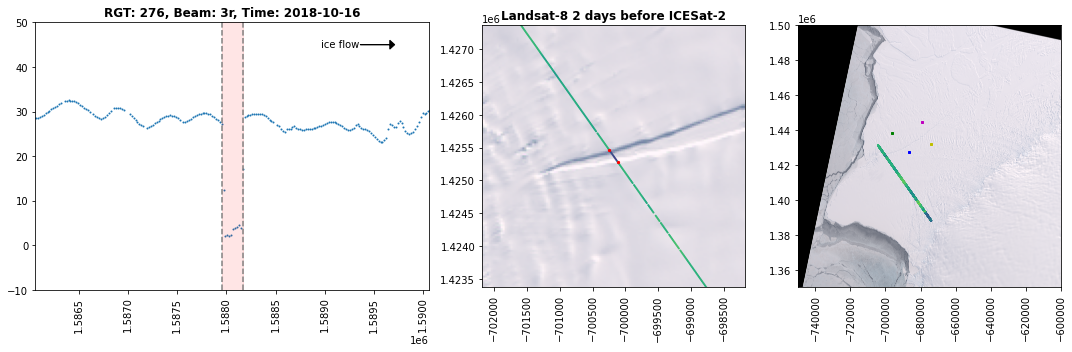

loading new Landsat-8 image: LC08_L1GT_182114_20181014_20201016_02_T2


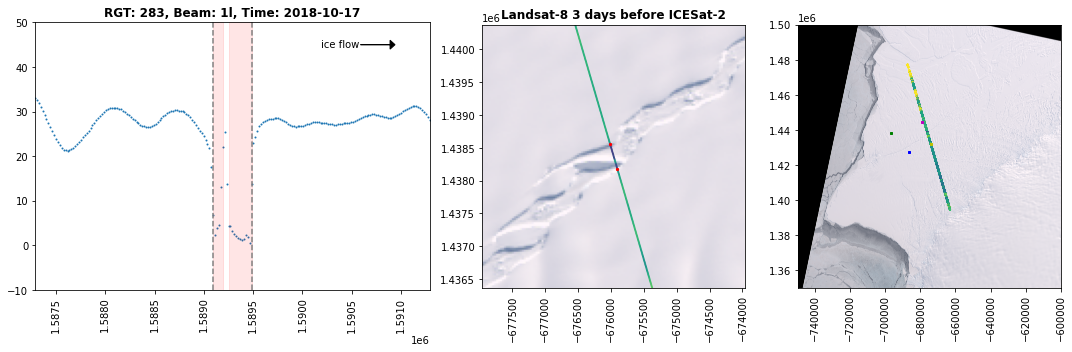

loading new Landsat-8 image: LC08_L1GT_182114_20181014_20201016_02_T2


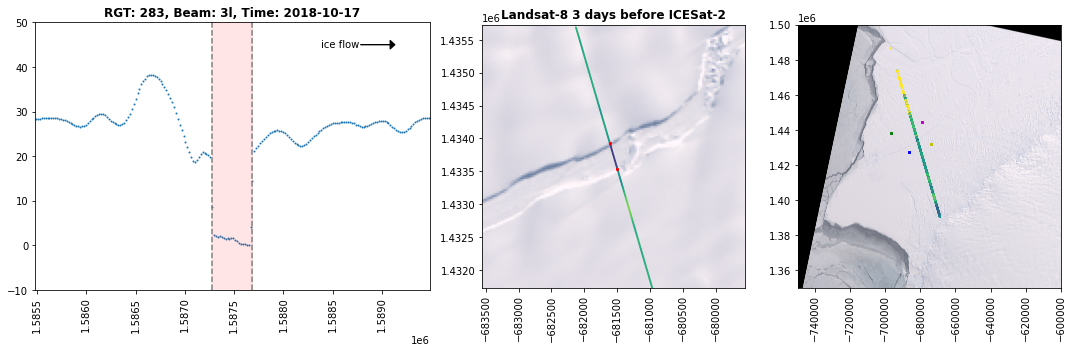

loading new Landsat-8 image: LC08_L1GT_182114_20181014_20201016_02_T2


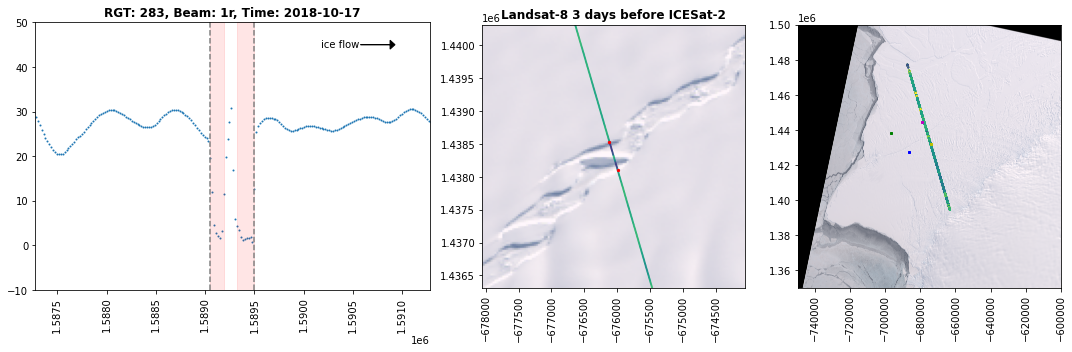

loading new Landsat-8 image: LC08_L1GT_182114_20181014_20201016_02_T2


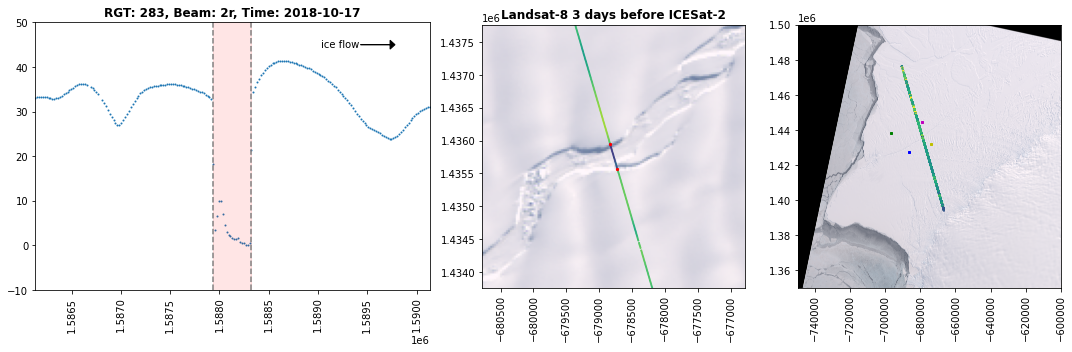

loading new Landsat-8 image: LC08_L1GT_182114_20181014_20201016_02_T2


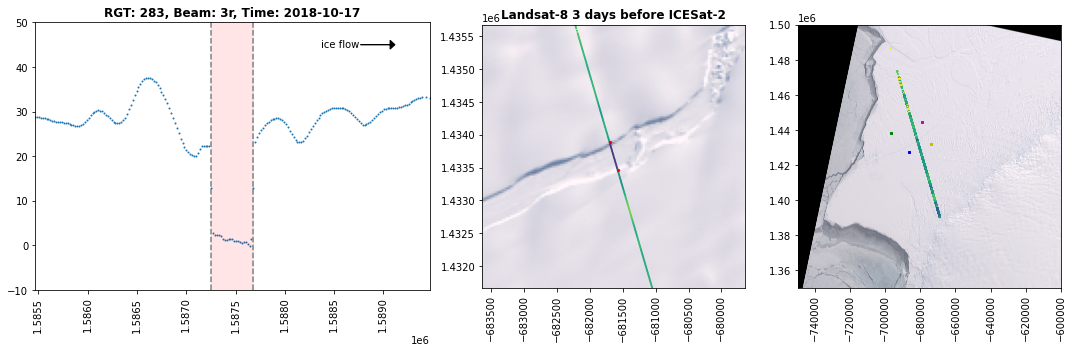

loading new Landsat-8 image: LC08_L1GT_183114_20181021_20201016_02_T2


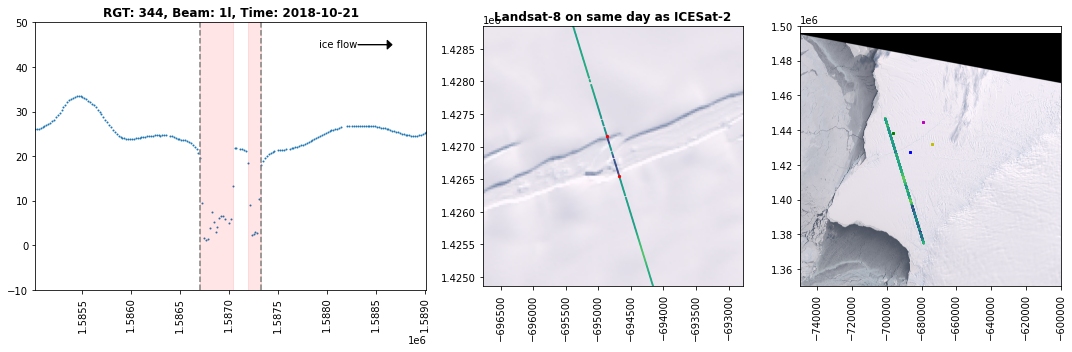

loading new Landsat-8 image: LC08_L1GT_183114_20181021_20201016_02_T2


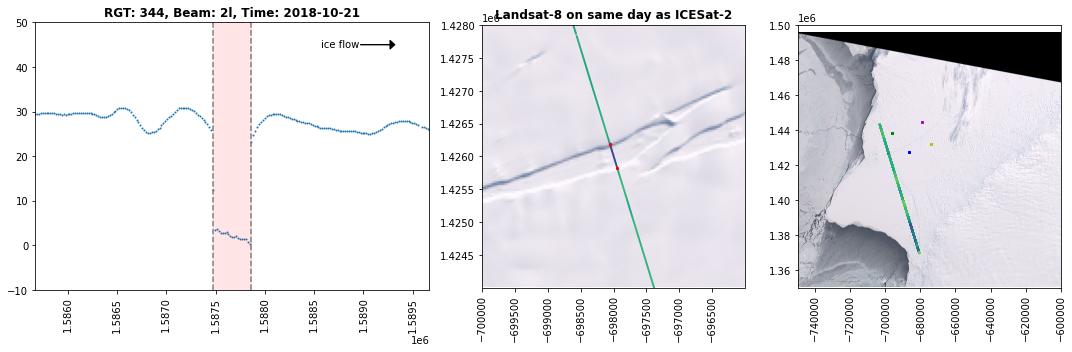

loading new Landsat-8 image: LC08_L1GT_183114_20181021_20201016_02_T2


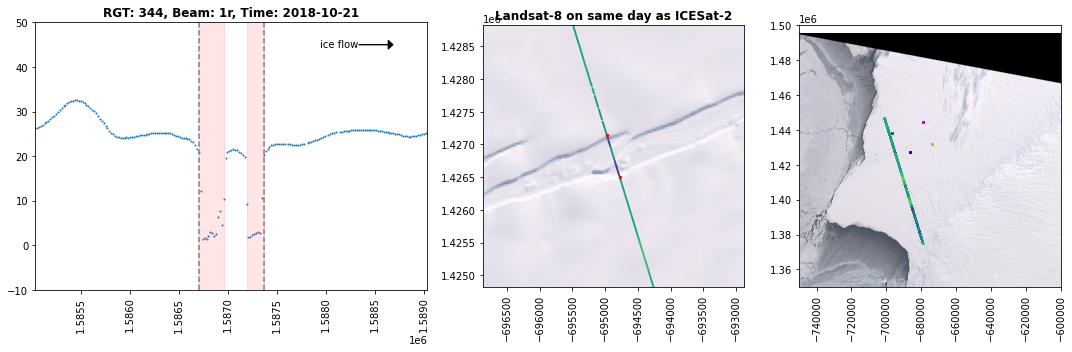

loading new Landsat-8 image: LC08_L1GT_183114_20181021_20201016_02_T2


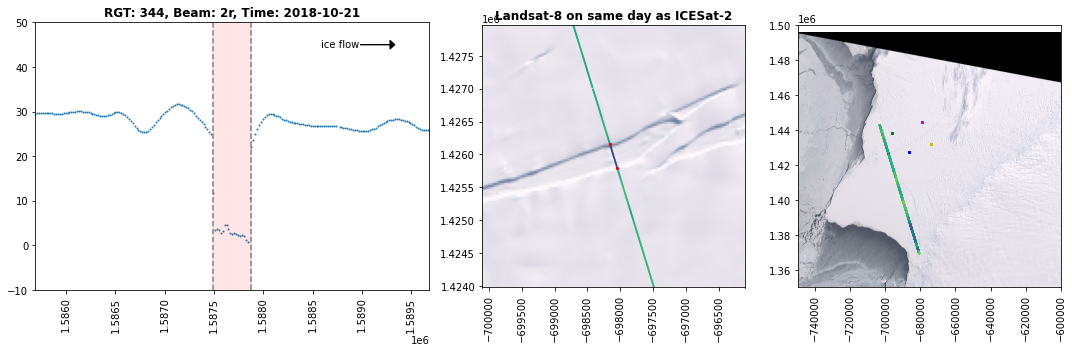

In [12]:
save_by_rgt = 1 # how to structure outputs 0: just list, 1:in rgt files
mdt = -1.1 #mean dynamic topography
plot_max = 50
plot_min = -10

def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return (d2-d1).days

satellite_path = '/home/ram21/notebooks/brunt-is2-rifts/halloween/'
output_path = satellite_path+'rift_calval_images_himedlow'

#dir_exist = os.path.exists(output_path)
#if not dir_exist:
#    os.makedirs(output_path)

# initialise (save reloading image when it was loaded in previous iteration)
satellite_loaded = 'none'

# interate through the merged rift detections
# change here to process a subset (time consuming...)
for i in range(0,10):
#for i in range(0,len(halloween_obs_merged)):
    
    # picks out the rift/rift parts from the unmerged observations
    rift = halloween_obs_merged.iloc[i]
    val = rift["data_row"]
    rift_parts = halloween_obs[halloween_obs['data_row'] == val]
    row = atl06_data.iloc[val]
    
    # check the ATL06 data and rift data match
    data_rgt  = row["rgt"]
    rift_rgt  = rift["rgt"]
    data_beam = row["beam"]
    rift_beam = rift["beam"]
    data_date = row["time"]
    rift_date = rift["time"]
    rift_only_date = str(rift_date.date())
    
    if (rift_rgt == data_rgt) & (rift_beam == data_beam) & (rift_date == data_date):
        
        #------------------------------
        # work out nearest satellite image
        difference = []

        for satdate in range (0,len(satellite_dates["dates"])):
            difference.append(days_between(rift_only_date,satellite_dates["dates"][satdate]))

        difference = np.array(difference)
        # second [0] means it defaults to a previous image
        # if before and after are the same number of days away
        min_diff_idx = int(np.where(abs(difference) == min(abs(difference)))[0][0])
        satellite_name = satellite_dates["scenes"][min_diff_idx]
        days_difference = difference[min_diff_idx]

        #------------------------------
        # load landsat-8
        
        if satellite_loaded != satellite_name:
            platform_name = 'Landsat-8'
            
            print("loading new Landsat-8 image: "+satellite_name)
            landsat_B4_name = satellite_path+'landsat/'+satellite_name+'/'+satellite_name+'_B4.TIF'
            landsat_B3_name = satellite_path+'landsat/'+satellite_name+'/'+satellite_name+'_B3.TIF'
            landsat_B2_name = satellite_path+'landsat/'+satellite_name+'/'+satellite_name+'_B2.TIF'

            band4 = rasterio.open(landsat_B4_name)
            band3 = rasterio.open(landsat_B3_name)
            band2 = rasterio.open(landsat_B2_name)
                
            # Prevent dull images
            b4 = band4.read(1)
            b4[b4>np.percentile(b4,99)] = np.percentile(b4,99)
            b3 = band3.read(1)
            b3[b3>np.percentile(b3,99)] = np.percentile(b3,99)
            b2 = band2.read(1)
            b2[b2>np.percentile(b2,99)] = np.percentile(b2,99)
                
            image = np.array([b4,b3,b2]).transpose(1,2,0)
            L8_to_plot = (image * (255 / np.max(image))).astype(np.uint8)
                
        #------------------------------
        # load ICESat-2 data/rift detection results
        h = row['h'] - row['geoid'] - row['tides'] - mdt
        d = np.sqrt(row['x']**2 + row['y']**2)
        d_centroid = np.sqrt(rift['x-centroid']**2 + rift['y-centroid']**2)
        d_start = rift['d-start']
        d_end = rift['d-end']
        
        d_landward = rift['d_landward']
        d_seaward = rift['d_seaward']
        h_landward = rift['h_landward']
        h_seaward = rift['h_seaward']
        sl_offset = rift['sl_offset']                
                
        #------------------------------
        # graph subplot
        fig,[ax1,ax2,ax3]=plt.subplots(1,3,figsize=(15,5),gridspec_kw={'width_ratios': [3,2,2]})
        ax1.set_ylim([plot_min,plot_max])
        ax1.set_xlim([d_centroid-2000,d_centroid+2000])
        ax1.set_title('RGT: %i, Beam: %s, Time: %s'%(rift_rgt,rift_beam,rift_only_date),fontweight='bold')
        # plot "wall-to-wall" width as dashed lines
        ax1.plot([d_start,d_start],[plot_min, plot_max], color = 'grey', linestyle = '--')
        ax1.plot([d_end,d_end],[plot_min, plot_max], color = 'grey', linestyle = '--')
        # plot "opening width" components as translucent rectangle
        for rp in range(0,len(rift_parts)):
            rp_d_start = rift_parts['d-start'].iloc[rp]
            rp_d_end = rift_parts['d-end'].iloc[rp]
            ax1.add_patch(Rectangle((rp_d_start,plot_min),rp_d_end-rp_d_start,plot_max-plot_min,edgecolor = 'red',facecolor = 'red',alpha = 0.1))
        
        ax1.scatter(d,h,s=1)
        ax1.tick_params('x', labelrotation=90)
        
        ax1.arrow(d_centroid+1300,plot_max-5,300,0,head_width=2,head_length=50,color='black')
        ax1.annotate("ice flow",(d_centroid+900,plot_max-5.5))
        
        # seaward-landward offset - not complete
        #if (sl_offset != np.nan):
        #    ax1.scatter(d_landward,h_landward,s=5,c='k')
        #    ax1.scatter(d_seaward,h_seaward,s=5,c='k')
        #    ax1.scatter(d_centroid-1850,plot_max-5,s=5,c='k')
        #    ax1.annotate("sl offset: "+str(round(sl_offset,2))+" m",(d_centroid-1800,plot_max-5.5))
                
        #------------------------------
        # Map subplot close
        if days_difference == 0:
            map_title = platform_name+' on same day as ICESat-2'
        if days_difference < 0:
            map_title = platform_name+' '+str(abs(days_difference))+' days before ICESat-2'
        if days_difference > 0: 
            map_title = platform_name+' '+str(days_difference)+' days after ICESat-2'
        
        show(L8_to_plot.transpose(2,0,1), transform=band2.transform,ax=ax2,title=map_title)
        ax2.scatter(row['x'],row['y'],c=h,vmin=plot_min,vmax=plot_max,s=1)
        # plot the edges
        ax2.scatter(rift['x-start'],rift['y-start'],c='r',s=5)
        ax2.scatter(rift['x-end'],rift['y-end'],c='r',s=5)
        # padding around centroid
        padding = 2e3
        ax2.set_xlim([rift['x-centroid']-padding,rift['x-centroid']+padding])
        ax2.set_ylim([rift['y-centroid']-padding,rift['y-centroid']+padding])
        ax2.tick_params('x', labelrotation=90)
        
        #------------------------------
        # Map subplot ice shelf
        show(L8_to_plot.transpose(2,0,1), transform=band2.transform,ax=ax3)
        ax3.scatter(row['x'],row['y'],c=h,vmin=plot_min,vmax=plot_max,s=1)
        ax3.set_xlim([-750000,-600000])
        ax3.set_ylim([1350000,1500000])
        ax3.tick_params('x', labelrotation=90)
        
        ax3.plot(np.mean(hh00_x),np.mean(hh00_y),'sg',markersize=2)
        ax3.plot(np.mean(tt05_x),np.mean(tt05_y),'sb',markersize=2)
        ax3.plot(np.mean(ss00_x),np.mean(ss00_y),'sm',markersize=2)
        ax3.plot(np.mean(tt04_x),np.mean(tt04_y),'sy',markersize=2)
                
        if save_by_rgt == 0:
            if i < 10:
                output = (output_path+'/halloween_rift_00'+str(i)+'_'+str(rift_only_date)+'_rgt'+str(rift_rgt)+'_'+rift_beam+'.png')
            if (i >= 10) & (i < 100):
                output = (output_path+'/halloween_rift_0'+str(i)+'_'+str(rift_only_date)+'_rgt'+str(rift_rgt)+'_'+rift_beam+'.png')
            if i >= 100:
                output = (output_path+'/halloween_rift_'+str(i)+'_'+str(rift_only_date)+'_rgt'+str(rift_rgt)+'_'+rift_beam+'.png')
        else:
            #rgt_dir_exist = os.path.exists(output_path+'/rgt_'+str(rift_rgt))

            #if not rgt_dir_exist:
                #os.makedirs(output_path+'/rgt_'+str(rift_rgt))
            
            if i < 10:
                output = (output_path+'/rgt_'+str(rift_rgt)+'/halloween_rift_00'+str(i)+'_'+str(rift_only_date)+'_rgt'+str(rift_rgt)+'_'+rift_beam+'.png')
            if (i >= 10) & (i < 100):
                output = (output_path+'/rgt_'+str(rift_rgt)+'/halloween_rift_0'+str(i)+'_'+str(rift_only_date)+'_rgt'+str(rift_rgt)+'_'+rift_beam+'.png')
            if i>= 100:
                output = (output_path+'/rgt_'+str(rift_rgt)+'/halloween_rift_'+str(i)+'_'+str(rift_only_date)+'_rgt'+str(rift_rgt)+'_'+rift_beam+'.png')
        
        plt.tight_layout()
        #plt.savefig(output, dpi=300, bbox_inches='tight')
        plt.show()
        
        #if i>19:
        #    break
        
    else:
        print("rift and ICESat-2 data files don't match")
        break


### Investigate all Halloween Crack rgts
Loop through RGTs and cycles plotting ATL06 for each beam along with rift measurements on graphs and Landsat-8 imagery with short temporal offset. These can be used to compare algorithm success with manual identification of Halloween Crack. See Table 1.

reference ground track: 276
number of dates: 11
number of cycles: 11.0
potential observations: 66
loading new Landsat-8 image: LC08_L1GT_182114_20181014_20201016_02_T2


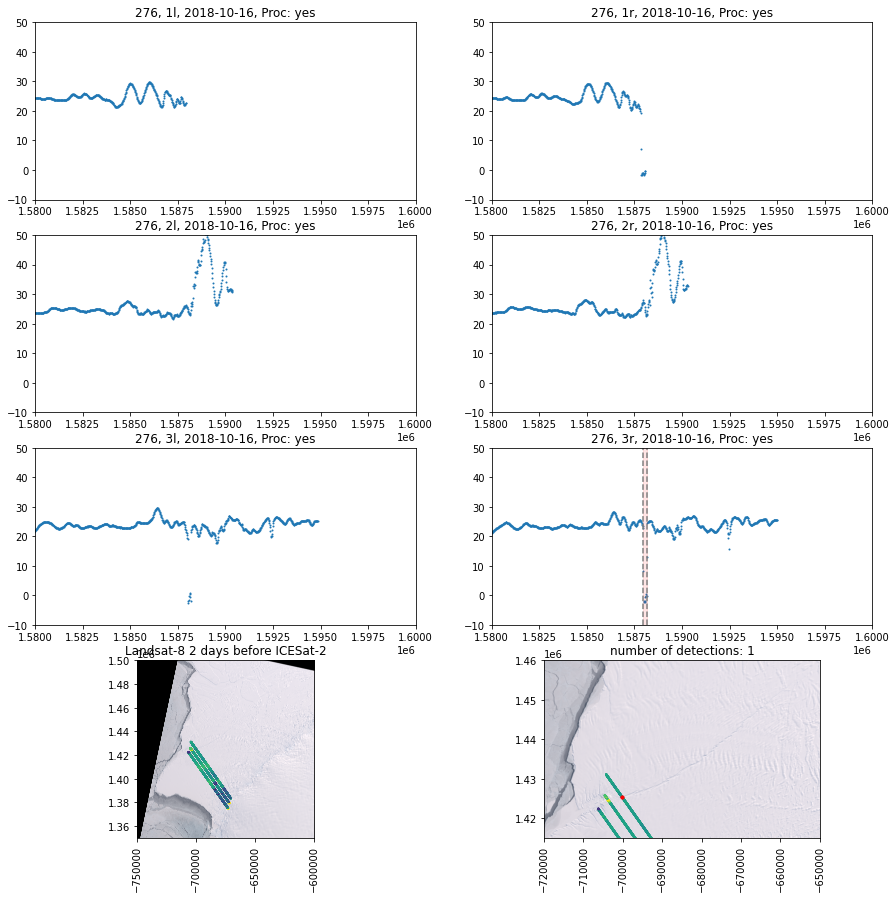

loading new Landsat-8 image: LC08_L1GT_182114_20190118_20201016_02_T2


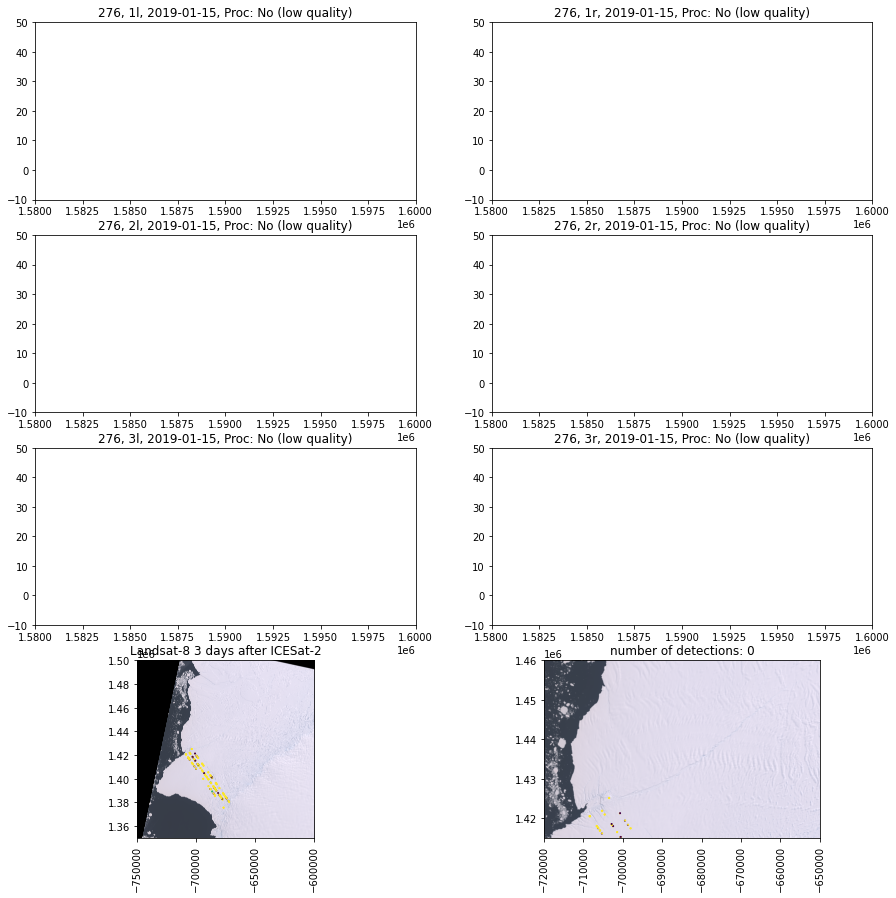

loading new Landsat-8 image: LC08_L1GT_182114_20190323_20200829_02_T2


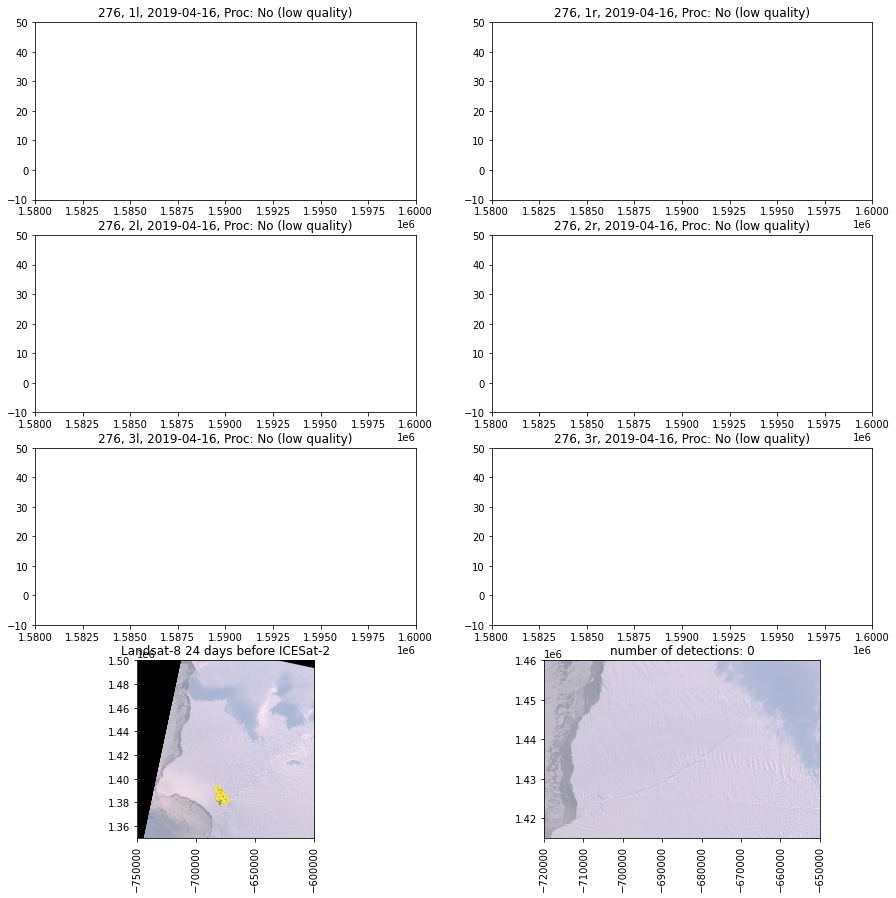

loading new Landsat-8 image: LC08_L1GT_182114_20191001_20200825_02_T2


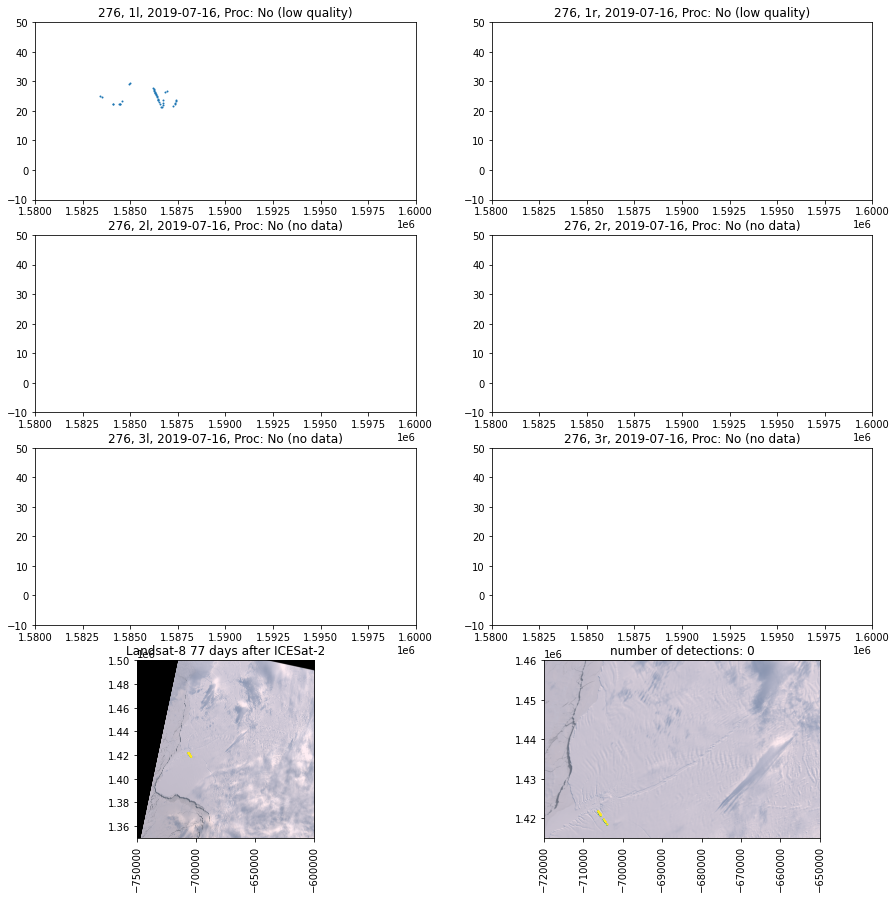

loading new Landsat-8 image: LC08_L1GT_182114_20191017_20201016_02_T2


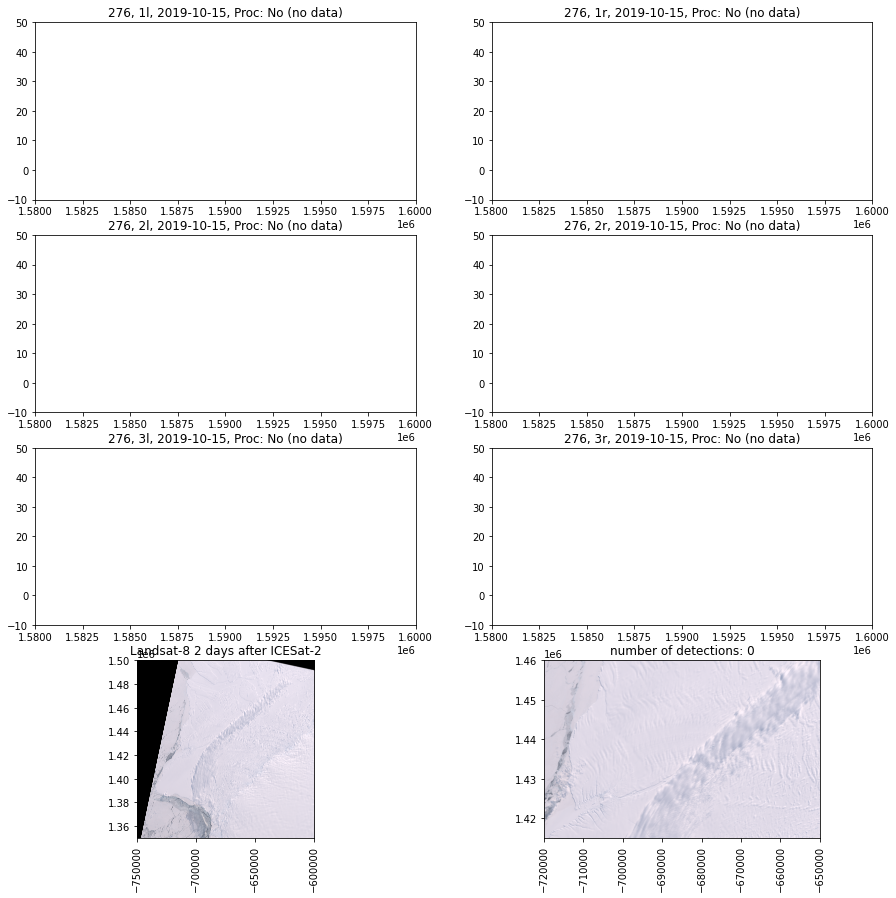

loading new Landsat-8 image: LC08_L1GT_183114_20200128_20201016_02_T2


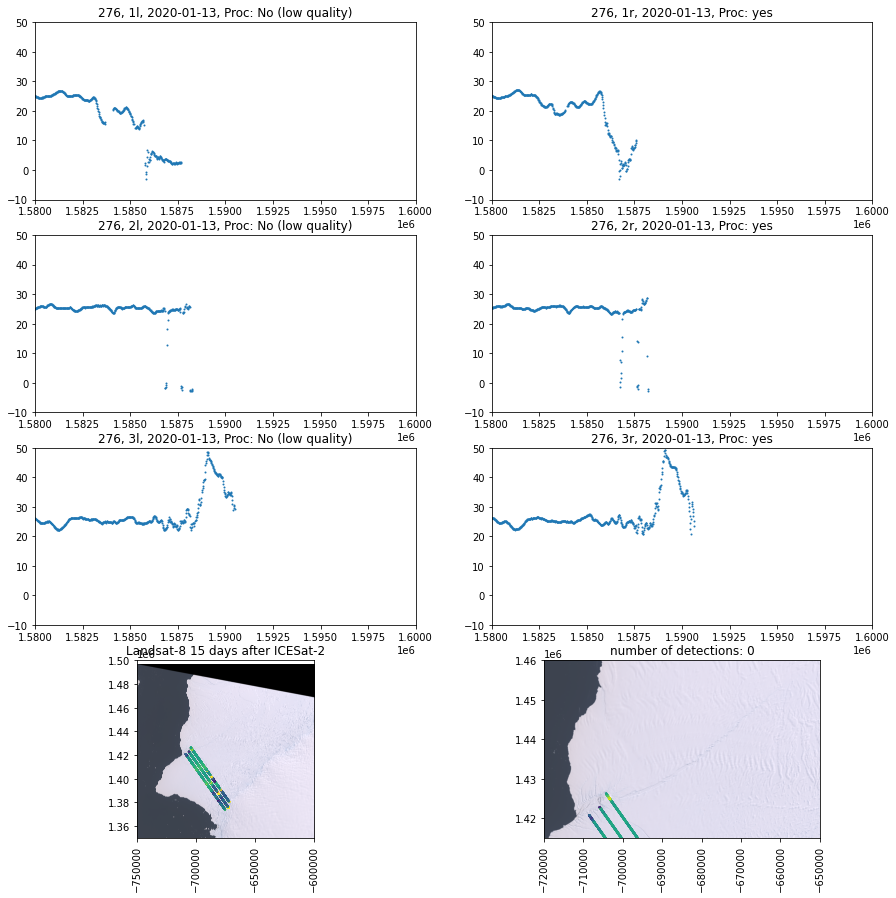

loading new Landsat-8 image: LC08_L1GT_182114_20200222_20201016_02_T2


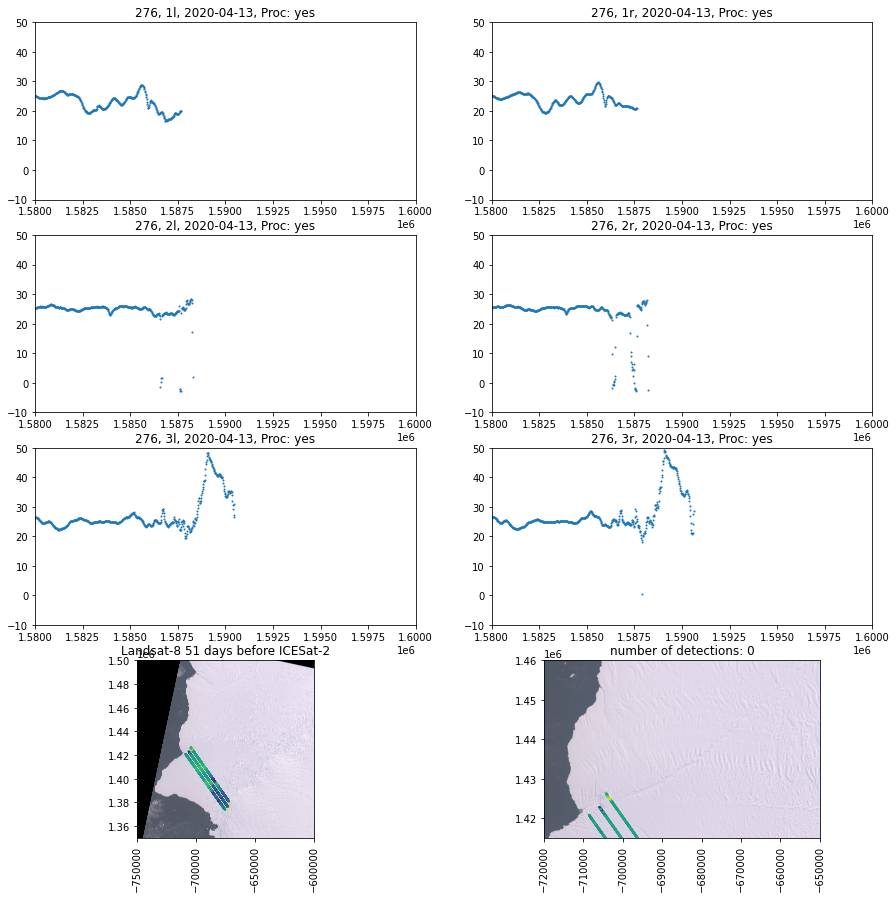

loading new Landsat-8 image: LC08_L1GT_183114_20200924_20201007_02_T2


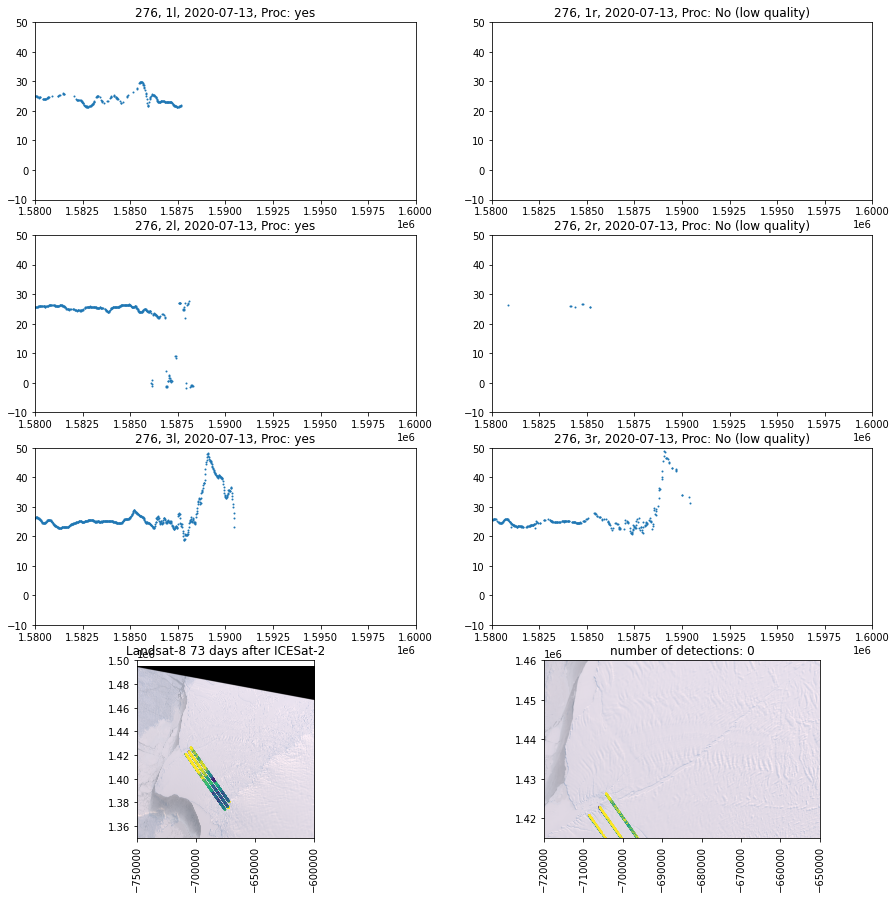

loading new Landsat-8 image: LC08_L1GT_182114_20210107_20210307_02_T2


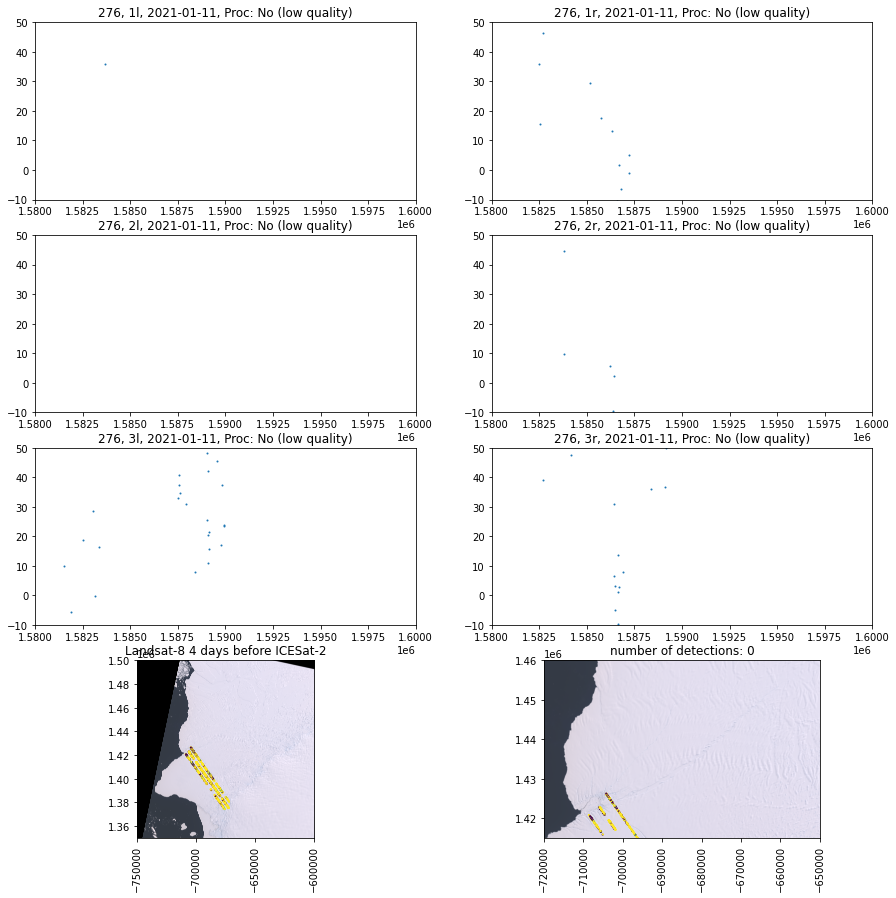

loading new Landsat-8 image: LC08_L1GT_184114_20210206_20210302_02_T2


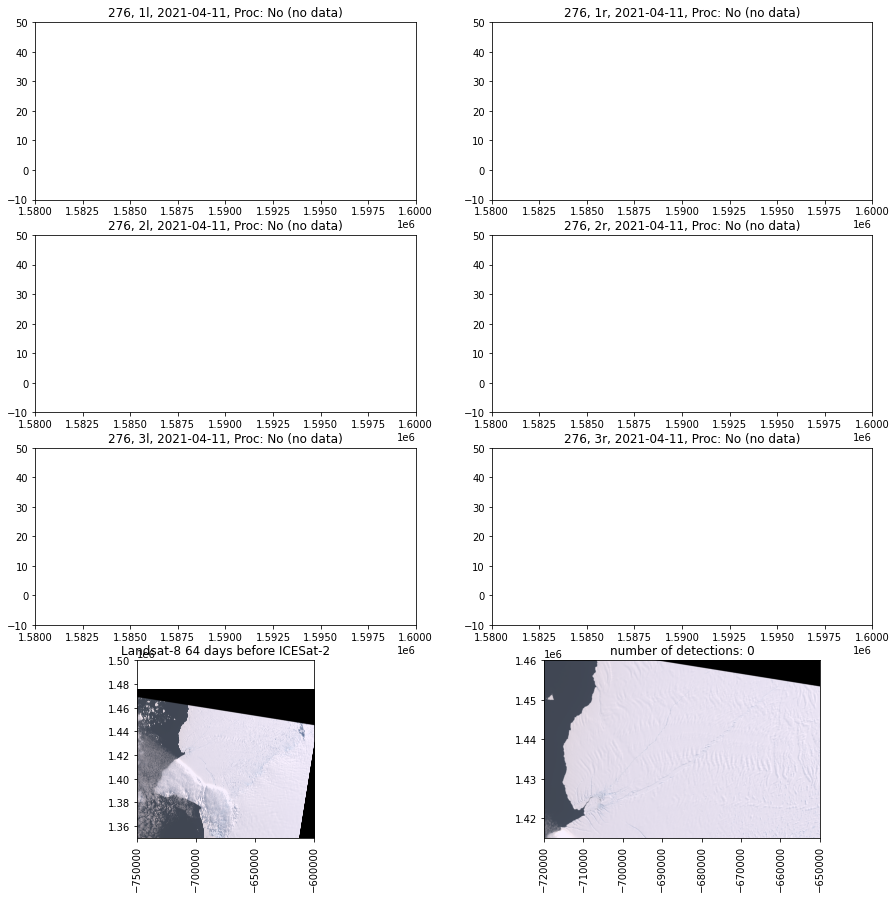

loading new Landsat-8 image: LC08_L1GT_182114_20210920_20210924_02_T2


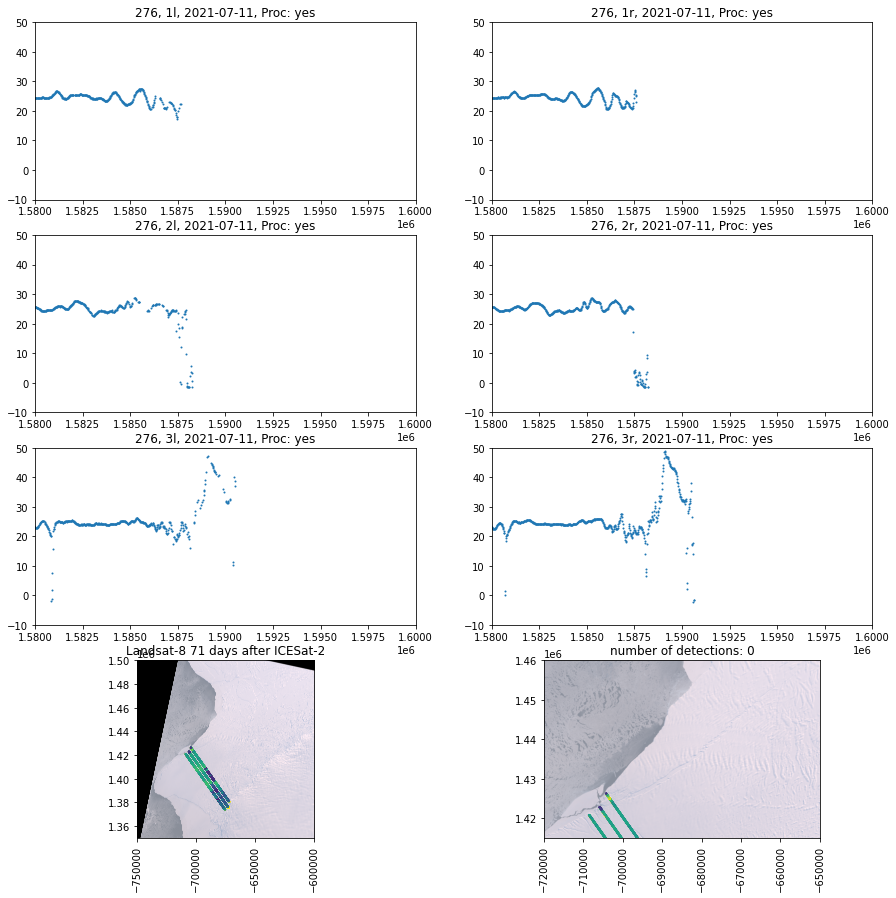

24 of 66 traces processed
rift found in 1 of the 24 processed traces (4%)
(possibility of some errors)

break down by rgt:
------------------------------
rgt: 276 processed: 24/66. rifts found: 1 (4%)
(can be greater than 100% if iceberg divides rift and it is detected as two separate rifts)
------------------------------


In [13]:
# Halloween Crack Reference Ground Tracks west to east (see Supplementary figure 2)
halloween_rgts = np.array([276,1289,718,344,1160,786,215,1228,657,283,1099,725,154,1167,596,222,1038])

satellite_path = '/home/ram21/notebooks/brunt-is2-rifts/halloween/'
output_path = '/home/ram21/notebooks/brunt-is2-rifts/halloween/rift_detection_analysis_merged_himedlow'

#dir_exist = os.path.exists(output_path)
#if not dir_exist:
#    os.makedirs(output_path)

plot_min = -10
plot_max = 50

#initialise
nr_tot_proc = 0
nr_tot_skip = 0
nr_tot_detect = 0

nr_rgt_proc_array = []
nr_rgt_skip_array = []
nr_rgt_detect_array = []

# interate through the RGTs and cycles
# change here to process a subset (time consuming...)
for t in range(0,1): 
#for t in range(0,len(halloween_rgts)):
    track = halloween_rgts[t]

    print("reference ground track: "+str(track))
    
    rgt_atl06_data = atl06_data[atl06_data["rgt"]==track]
    #display(rgt_atl06_data)
    
    track_dates = rgt_atl06_data["time"].drop_duplicates()
    
    print("number of dates: "+str(len(track_dates)))
    print("number of cycles: "+str(len(rgt_atl06_data)/6))
    print("potential observations: "+str(len(rgt_atl06_data)))
    
    if len(track_dates) != len(rgt_atl06_data)/6:
        break
    
    #track_dir_exist = os.path.exists(output_path+'/rgt_'+str(track))
    #if not track_dir_exist:
    #    os.makedirs(output_path+'/rgt_'+str(track))
    
    #initialise
    nr_rgt_proc = 0
    nr_rgt_skip = 0
    nr_rgt_detect = 0
    
    for sat_pass in track_dates:
        #print(sat_pass)
    
        pass_date = str(sat_pass.date())
    
        sat_pass_atl06_data = rgt_atl06_data[rgt_atl06_data["time"]==sat_pass]
        #display(sat_pass_atl06_data)
        
        #------------------------------
        # work out nearest satellite image
        difference = []

        for satdate in range (0,len(satellite_dates["dates"])):
            difference.append(days_between(pass_date,satellite_dates["dates"][satdate]))

        difference = np.array(difference)
        # second [0] means it defaults to a previous image
        # if before and after are the same number of days away
        min_diff_idx = int(np.where(abs(difference) == min(abs(difference)))[0][0])
        satellite_name = satellite_dates["scenes"][min_diff_idx]
        days_difference = difference[min_diff_idx]
        
        print("loading new Landsat-8 image: "+satellite_name)
        landsat_B4_name = satellite_path+'landsat/'+satellite_name+'/'+satellite_name+'_B4.TIF'
        landsat_B3_name = satellite_path+'landsat/'+satellite_name+'/'+satellite_name+'_B3.TIF'
        landsat_B2_name = satellite_path+'landsat/'+satellite_name+'/'+satellite_name+'_B2.TIF'

        band4 = rasterio.open(landsat_B4_name)
        band3 = rasterio.open(landsat_B3_name)
        band2 = rasterio.open(landsat_B2_name)
                
        # Prevent dull images
        b4 = band4.read(1)
        b4[b4>np.percentile(b4,99)] = np.percentile(b4,99)
        b3 = band3.read(1)
        b3[b3>np.percentile(b3,99)] = np.percentile(b3,99)
        b2 = band2.read(1)
        b2[b2>np.percentile(b2,99)] = np.percentile(b2,99)
                
        image = np.array([b4,b3,b2]).transpose(1,2,0)
        L8_to_plot = (image * (255 / np.max(image))).astype(np.uint8)
        
        output = (output_path+'/rgt_'+str(track)+'/date_'+str(pass_date)+'.png') 
        
        fig,axs=plt.subplots(4,2,figsize=(15,15)) 
        axs=axs.ravel()
        
        if days_difference == 0:
            map_title = 'Landsat-8 on same day as ICESat-2'
        if days_difference < 0:
            map_title = 'Landsat-8 '+str(abs(days_difference))+' days before ICESat-2'
        if days_difference > 0: 
            map_title = 'Landsat-8 '+str(days_difference)+' days after ICESat-2'
        show(L8_to_plot.transpose(2,0,1), transform=band2.transform,ax=axs[6])
        
        show(L8_to_plot.transpose(2,0,1), transform=band2.transform,ax=axs[7]) 
        
        the_beams = ([0,3,1,4,2,5])
        
        #initialise
        nr_detect = 0
        
        for b in range(6):
            bb = the_beams[b]
            pass_beam = sat_pass_atl06_data["beam"].iloc[bb]
            #print(pass_beam)
            pass_h = sat_pass_atl06_data["h"].iloc[bb]
            pass_geoid = sat_pass_atl06_data["geoid"].iloc[bb]
            pass_tides = sat_pass_atl06_data["tides"].iloc[bb]
            #pass_h = pass_h - pass_geoid - pass_tides
            pass_x = sat_pass_atl06_data["x"].iloc[bb]
            pass_y = sat_pass_atl06_data["y"].iloc[bb]
            pass_d = np.sqrt(pass_y**2 + pass_x**2)
            pass_q = sat_pass_atl06_data["quality"].iloc[bb]
           
            if len(pass_q) > 0:
                
                percent_low_quality = sum( pass_q==1 )  / len(pass_q)
                
                spacing = (max(pass_d) - min(pass_d)) / len(pass_d)            
                pass_sep = np.zeros(len(pass_d)-1)
                pass_below = np.zeros(len(pass_d)-1)
                
                for i in range(1,len(pass_d)):
                    pass_sep[i-1]=pass_d[i]-pass_d[i-1]
                    if abs(pass_d[i]-pass_d[i-1]) < 25:
                        pass_below[i-1] = 1   
                pass_percent = (np.sum(pass_below)/len(pass_below))*100
                        
            else:
                percent_low_quality = 100
                spacing = 100
                
                pass_percent = 0
            
            # reason a beam is not processed
            if len(pass_q) == 0:
                comment = "No (no data)"
                nr_tot_skip += 1
                nr_rgt_skip += 1
            elif len(pass_h) < 10:
                comment = "No (too few data)"
                nr_tot_skip += 1
                nr_rgt_skip += 1
            elif percent_low_quality > 0.2:
                comment = "No (low quality)"
                nr_tot_skip += 1
                nr_rgt_skip += 1
            elif (spacing > 25) & (pass_percent < 97):
                comment = "No (spacing/gaps)"
                nr_tot_skip += 1
                nr_rgt_skip += 1
            else:
                comment = "yes"
                nr_tot_proc += 1
                nr_rgt_proc += 1
            
            axs[b].scatter(pass_d,pass_h,s=1)   
            axs[b].set_title('%i, %s, %s, Proc: %s'%(track,pass_beam,pass_date,comment))
            axs[b].set_ylim(plot_min,plot_max)
            axs[b].set_xlim(1580000,1600000)
            
            #plot on the map too
            axs[6].scatter(pass_x,pass_y,c=pass_h,vmin=plot_min,vmax=plot_max,s=1)
            axs[6].set_xlim([-750000,-600000])
            axs[6].set_ylim([1350000,1500000])
            axs[6].tick_params('x', labelrotation=90)
            axs[7].scatter(pass_x,pass_y,c=pass_h,vmin=plot_min,vmax=plot_max,s=1)
            axs[7].set_xlim(-720000,-650000)
            axs[7].set_ylim(1415000,1460000)
            axs[7].tick_params('x', labelrotation=90)
        
            the_indiv_rifts = halloween_obs[(halloween_obs["rgt"]==track) & (halloween_obs["time"]==sat_pass) & (halloween_obs["beam"]==pass_beam)]
            the_rifts = halloween_obs_merged[(halloween_obs_merged["rgt"]==track) & (halloween_obs_merged["time"]==sat_pass) & (halloween_obs_merged["beam"]==pass_beam)]
            
            if len(the_rifts)>0:
                nr_detect += len(the_rifts)
                nr_rgt_detect += len(the_rifts)
                nr_tot_detect += len(the_rifts)
                
                d_indiv_starts = np.array(the_indiv_rifts['d-start'])
                d_indiv_ends = np.array(the_indiv_rifts['d-end'])
                d_starts = np.array(the_rifts['d-start'])
                d_ends = np.array(the_rifts['d-end'])
                x_centroids = np.array(the_rifts['x-centroid'])
                y_centroids = np.array(the_rifts['y-centroid'])
                
                for ri in range(0,len(the_indiv_rifts)):
                    d_indiv_start = d_indiv_starts[ri]
                    d_indiv_end = d_indiv_ends[ri]
                
                    axs[b].add_patch(Rectangle((d_indiv_start,plot_min),d_indiv_end-d_indiv_start,plot_max-plot_min,edgecolor = 'red',facecolor = 'red',alpha = 0.1))
        
                for r in range(0,len(the_rifts)):
                    #display(pass_rift)
                    d_start = d_starts[r]
                    d_end = d_ends[r]
                    x_centroid = x_centroids[r]
                    y_centroid = y_centroids[r]
                    
                    axs[b].plot([d_start,d_start],[plot_min, plot_max], color = 'grey', linestyle = '--')
                    axs[b].plot([d_end,d_end],[plot_min, plot_max], color = 'grey', linestyle = '--')
        
                    axs[7].scatter(x_centroid,y_centroid,c='r',s=10)
                    
        axs[6].set_title(map_title)
        axs[7].set_title("number of detections: "+str(nr_detect))
        
        #plt.savefig(output, dpi=300, bbox_inches='tight')
        plt.show()
        
    nr_rgt_proc_array.append(nr_rgt_proc)
    nr_rgt_skip_array.append(nr_rgt_skip)
    nr_rgt_detect_array.append(nr_rgt_detect)
        
print(str(nr_tot_proc)+" of "+str(nr_tot_proc+nr_tot_skip)+" traces processed")
print("rift found in "+str(nr_tot_detect)+" of the "+str(nr_tot_proc)+" processed traces ("+str(round((nr_tot_detect/nr_tot_proc)*100))+"%)")
print("(possibility of some errors)")
print("")
print("break down by rgt:")
print("------------------------------")
for tr in range(0,len(nr_rgt_proc_array)):
    if nr_rgt_proc_array[tr] > 0:
        print("rgt: "+str(halloween_rgts[tr])+" processed: "+str(nr_rgt_proc_array[tr])+"/"+\
         str(nr_rgt_proc_array[tr]+nr_rgt_skip_array[tr])+". rifts found: "+str(nr_rgt_detect_array[tr])+\
         " ("+str(round((nr_rgt_detect_array[tr]/nr_rgt_proc_array[tr])*100))+"%)")
    else:
        print("rgt: "+str(halloween_rgts[tr])+" processed: "+str(nr_rgt_proc_array[tr])+"/"+\
         str(nr_rgt_proc_array[tr]+nr_rgt_skip_array[tr])+". rifts found: n/a")
print("(can be greater than 100% if iceberg divides rift and it is detected as two separate rifts)")
print("------------------------------")




In [14]:
print(nr_rgt_detect_array)

[1]


### Detection success
Comparison of algorithm performance compared to manual identification of rifts (some will be thrown out by the quality thresholds) for table 1.

In [15]:
# rgts: 276,1289,718,344,1160,786,215,1228,657,283,1099,725,154,1167,596,222,1038

# to save running previous cell for all RGTs and cycles again (time consuming...)
# number of rift measurements by algorithm per RGT
nr_rgt_detect_array = ([1,7,13,24,26,49,51,36,30,26,23,23,26,19,21,7,1])
# number of rifts identified manually per RGT
nr_rgt_manual_array = ([2,6,12,27,28,58,54,40,33,27,23,26,30,24,34,12,4])
# number of rift measurements by algorithm that were not Halloween Crack per RGT
nr_rgt_not_hc       = ([0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
# number of underestimated rifts (called "errors" in paper)
nr_rgt_error        = ([0,0,0,0,0,0,0,0,1,0,0,1,1,0,2,0,0])


print("break down by rgt:")
print("--------------------------------------------------")
print("McDonald ice rise")
print(" ")

#for tr in range(0,len(nr_rgt_proc_array)):
for tr in range(0,len(nr_rgt_detect_array)):
    if halloween_rgts[tr] < 1000:
        print_rgt    = ("rgt:  "+str(halloween_rgts[tr])+". ")
    else:
        print_rgt    = ("rgt: "+str(halloween_rgts[tr])+". ")
    
    if nr_rgt_manual_array[tr] < 10:
        print_manual = ("manually:   "+str(nr_rgt_manual_array[tr])+". ")
    else:
        print_manual = ("manually:  "+str(nr_rgt_manual_array[tr])+". ")
    
    if nr_rgt_detect_array[tr]-nr_rgt_error[tr]-nr_rgt_not_hc[tr] < 10:
        print_auto   = ("automatically:   "+str(nr_rgt_detect_array[tr]-nr_rgt_not_hc[tr])+" ")
    else:
        print_auto   = ("automatically:  "+str(nr_rgt_detect_array[tr]-nr_rgt_not_hc[tr])+" ")
    
    if nr_rgt_error[tr] < 10:
        print_error  = ("errors:  "+str(nr_rgt_error[tr]))
    else:
        print_error  = ("errors: "+str(nr_rgt_error[tr]))
    
    rgt_percent = round(((nr_rgt_detect_array[tr]-nr_rgt_error[tr]-nr_rgt_not_hc[tr])/nr_rgt_manual_array[tr])*100)
    if rgt_percent < 10:
        print_perc   = ("(  "+str(rgt_percent)+"%). ")
    elif (rgt_percent >= 10) & (rgt_percent < 100):
        print_perc   = ("( "+str(rgt_percent)+"%). ")
    else:
        print_perc   = ("("+str(rgt_percent)+"%). ")
    
    print(print_rgt+print_manual+print_auto+print_perc+print_error)

tot_percent = round(((sum(nr_rgt_detect_array)-sum(nr_rgt_not_hc))/sum(nr_rgt_manual_array))*100)
    
print(" ")
print("Total:     manually: "+str(sum(nr_rgt_manual_array))+". automatically: "+\
      str(sum(nr_rgt_detect_array)-sum(nr_rgt_not_hc))+\
      " ( "+str(tot_percent)+"%). errors:  "+str(sum(nr_rgt_error)))
print(" ")        
print("Stancomb Wills")    
print("--------------------------------------------------")



break down by rgt:
--------------------------------------------------
McDonald ice rise
 
rgt:  276. manually:   2. automatically:   1 ( 50%). errors:  0
rgt: 1289. manually:   6. automatically:   5 ( 83%). errors:  0
rgt:  718. manually:  12. automatically:  12 (100%). errors:  0
rgt:  344. manually:  27. automatically:  24 ( 89%). errors:  0
rgt: 1160. manually:  28. automatically:  26 ( 93%). errors:  0
rgt:  786. manually:  58. automatically:  49 ( 84%). errors:  0
rgt:  215. manually:  54. automatically:  51 ( 94%). errors:  0
rgt: 1228. manually:  40. automatically:  36 ( 90%). errors:  0
rgt:  657. manually:  33. automatically:  30 ( 88%). errors:  1
rgt:  283. manually:  27. automatically:  26 ( 96%). errors:  0
rgt: 1099. manually:  23. automatically:  23 (100%). errors:  0
rgt:  725. manually:  26. automatically:  23 ( 85%). errors:  1
rgt:  154. manually:  30. automatically:  26 ( 83%). errors:  1
rgt: 1167. manually:  24. automatically:  19 ( 79%). errors:  0
rgt:  596. man